# Text Classification  

> Chapter 1 - learn about using a neural network to classify text using sentiment (positive or negative).

- toc: true
- branch: master
- badges: false
- comments: false
- annotations: true

# Introduction

Text classification is the process of assigning tags or categories to text according to its content. It’s one of the fundamental tasks in natural language processing.

The text we wanna classify is given as input to an algorithm, the algorithm will then analyze the text’s content, and then categorize the input as one of the tags or categories previously given.

**Input → Classifying Algorithm → Classification of Input**

Real life examples:

- Sentiment analysis: how does the writer of the sentence feel about what they are writing about, do they think positively or negatively of the subject? Ex. restaurant reviews topic labeling: given sentences and a set of topics, which topic does this sentence fall under? Ex. is this essay about history? Math? etc? spam detection Ex. Email filtering: is this email a real important email or spam?

Example. A restaurant wants to evaluate their ratings but don’t want to read through all of them. Therefore, they wanna use a computer algorithm to do all their work. They simply want to know if the customer’s review is positive or negative.

Here’s an example of a customer’s review and a simple way an algorithm could classify their review.

Input: “The food here was too salty and too expensive”

Algorithm: Goes through every word in the sentence and counts how many positive words and how many negative words are in the sentence.

```
    “The, food, here, was, too, and” are all neutral words

    “Salty, expensive” are negative words.

    Negative words: 2
    Positive words: 0
```

Classification: Negative Review, because there are more negative words (2) than positive (0).

However, this algorithm obviously doesn’t work in a lot of cases.

For example, “The food here was good, not expensive and not salty” would be classified as negative but it’s actually a positive review.

Language and text can get very complicated which makes creating these algorithms difficult. Some things that make language difficult could be words that have multiple meanings, negation words (words such as not), slang, etc.

# Set up data and imports

## Library imports

This section of code is to import any necessary Python libraries that we'll need for the rest of this notebook. Some packages may need to be installed since they are not built in to Python3.

In [1]:
# collapse-hide
# !pip3 install seaborn
# !pip3 install plotly --user
# !pip3 install sklearn

import os
import sys
import string
from scipy import sparse
from pprint import pprint
import pandas as pd
import seaborn as sns
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)
import matplotlib.pyplot as plt
import numpy as np
from html import escape
from IPython.core.display import display, HTML
from string import Template
from sklearn.metrics import classification_report
import json

HTML('<script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>')


## Getting our data 

Below is a definition of getData, a basic function to pull from the `trainingSet.txt` and `testSet.txt`. The data that we're using for this example is a set of reviews written by users on Yelp, classified as positive (1) or negative (0). 

We open the file, create temporary arrays, and pull from the file line by line.

Open the cell if you'd like to peek into what the function looks like.

In [2]:
# collapse-hide
# Our two files that contain our data, split up into a training set and a testing set.

trainingFile = "dataset/trainingSet.txt"
testingFile = "dataset/testSet.txt"

def getData(fileName):
    f = open(fileName)
    file = f.readlines()

    sentences = []
    sentiments = []

    for line in file:
        sentence, sentiment = line.split('\t')
        sentences.append(sentence.strip())
        sentiments.append(int(sentiment.strip())) # Sentiment in {0,1}

    return sentences, np.array(sentiments)

In [3]:
# get data from the training and testing files using the getData function defined above

trainingSentences, trainingLabels = getData(trainingFile)
testingSentences, testingLabels = getData(testingFile) 

Let's take a peek at what this data looks like:

In [4]:
#collapse-hide 

f = open(trainingFile)
file = f.readlines()

sentences = []
sentiments = []

for line in file:
    sentence, sentiment = line.split('\t')
    sentences.append(sentence.strip())
    sentiments.append(int(sentiment.strip())) 
    
print("Sample sentences:")
pprint(sentences[:10]) 
print("Corresponding sentiments:")
pprint(sentiments[:10]) 

Sample sentences:
['Wow... Loved this place.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation '
 'and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead '
 'of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.']
Corresponding sentiments:
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1]


## Pre-processing our data 

We need to modify these sentences by tokenizing them into individual strings (word by word) so that we can feed our model individual words and their associated sentiment (negative / positive).

In [5]:
def preProcess(sentences):

    def cleanText(text):
        # Make lower case
        text = text.lower()

        # Replace non-text characters with spaces
        nonText = string.punctuation + ("")
        text = text.translate(str.maketrans(nonText, ' ' * (len(nonText))))

        # Split sentences into individual words - tokenize
        words = text.split()

        return words

    return list(map(cleanText, sentences))

In [6]:
# Process both the training and testing tokens.

trainingTokens = preProcess(trainingSentences)
testingTokens = preProcess(testingSentences)

Let's look at what these tokenized sentences look like now:

In [7]:
#collapse-hide
print("Training tokens:")
pprint(trainingTokens[:2]) 
print("Testing tokens:")
pprint(testingTokens[:3]) 

Training tokens:
[['wow', 'loved', 'this', 'place'],
 ['not', 'tasty', 'and', 'the', 'texture', 'was', 'just', 'nasty']]
Testing tokens:
[['crust', 'is', 'not', 'good'],
 ['would', 'not', 'go', 'back'],
 ['i', 'was', 'shocked', 'because', 'no', 'signs', 'indicate', 'cash', 'only']]


## Vectorizing our data

Now that we have our sentences tokenized, notice how our training tokens are nested arrays. We want to pull them out of nested arrays and into just one general vocabulary list.

In [8]:
#collapse-hide

def getVocab(sentences):
    vocab = set()
    for sentence in sentences:
        for word in sentence:
            vocab.add(word)
    return sorted(vocab)

In [9]:
# Pull trainingTokens into one vocabulary listed, no nested arrays

vocabulary = getVocab(trainingTokens)

We can peek at our vocabulary list, an alphabetically sorted list of words, now at a random set of indices:

In [10]:
#collapse-hide

pprint(vocabulary[50:70])

['amount',
 'an',
 'and',
 'angry',
 'another',
 'anticipated',
 'any',
 'anything',
 'anytime',
 'anyway',
 'apologize',
 'app',
 'appalling',
 'appetizers',
 'apple',
 'approval',
 'are',
 'area',
 'aren',
 'aria']


We want our arrays to actually be proper vectors to feed to our model, which we'll create below as well. This function, ```createVector``` transforms our arrays into vectors. 

In [11]:
def createVector(vocab, sentences):
    indices = []
    wordOccurrences = []

    for sentenceIndex, sentence in enumerate(sentences):
        alreadyCounted = set() # Keep track of words so we don't double count.
        for word in sentence:
            if (word in vocab) and word not in alreadyCounted:
                # If we just want {0,1} for the presence of the word (bernoulli NB),
                # only count each word once. Otherwise (multinomial NB) count each
                # occurrence of the word.
                
            
                #which sentence, which word
                indices.append((sentenceIndex, vocab.index(word)))
                
                wordOccurrences.append(1)
                alreadyCounted.add(word)

    # Unzip
    rows = [row for row, _ in indices]
    columns = [column for _, column in indices]

    sentenceVectors = sparse.csr_matrix((wordOccurrences, (rows, columns)), dtype=int, shape=(len(sentences), len(vocab)))

    return sentenceVectors

In [12]:
training = createVector(vocabulary, trainingTokens)
testing = createVector(vocabulary, testingTokens)

Our training and test data has gone through some transformation. Here's what the training data looks like now:

In [13]:
#collapse-hide

print("Training data:")
print(training[:2])

Training data:
  (0, 694)	1
  (0, 884)	1
  (0, 1186)	1
  (0, 1335)	1
  (1, 52)	1
  (1, 640)	1
  (1, 768)	1
  (1, 788)	1
  (1, 1158)	1
  (1, 1166)	1
  (1, 1171)	1
  (1, 1281)	1


# A Naive Bayes model

## Creating and Training our Model

Below is our Naive Bayes classifier, which is the model we've chosen to use for our sentiment analysis of restaurant reviews.

In [14]:
class NaiveBayesClassifier:
    def __init__(self):
        self.priorPositive = None  # Probability that a review is positive
        self.priorNegative = None  # Probability that a review is negative
        self.positiveLogConditionals = None
        self.negativeLogConditionals = None

    def computePriorProbabilities(self, labels):
        self.priorPositive = len([y for y in labels if y == 1]) / len(labels)
        self.priorNegative = 1 - self.priorPositive

    def computeConditionProbabilities(self, examples, labels, dirichlet=1):
        _, vocabularyLength = examples.shape

        # How many of each word are there in all of the positive reviews
        positiveCounts = np.array([dirichlet for _ in range(vocabularyLength)])
        # How many of each word are there in all of the negative reviews
        negativeCounts = np.array([dirichlet for _ in range(vocabularyLength)])

        # Here's how to iterate through a spare array
        coordinates = examples.tocoo()  # Converted to a `coordinate` format
        for exampleIndex, featureIndex, observationCount in zip(coordinates.row, coordinates.col, coordinates.data):
            # For sentence {exampleIndex}, for word at index {featureIndex}, the word occurred {observationCount} times
            if labels[exampleIndex] == 1:
                positiveCounts[featureIndex] += observationCount
            else:
                negativeCounts[featureIndex] += observationCount

        # [!] Make sure to use the logs of the probabilities
        positiveReviewCount = len([y for y in labels if y == 1])
        negativeReviewCount = len([y for y in labels if y == 0])

        # We are using bernoulli NB (single occurance of a word)
        self.positiveLogConditionals = np.log(positiveCounts) - np.log(positiveReviewCount + dirichlet*2)
        self.negativeLogConditionals = np.log(negativeCounts) - np.log(negativeReviewCount + dirichlet*2)

        # This works for multinomial NB (multiple occurances of a word)
        # self.positiveLogConditionals = np.log(positiveCounts) - np.log(sum(positiveCounts))
        # self.negativeLogConditionals = np.log(negativeCounts) - np.log(sum(negativeCounts))

    # Calculate all of the parameters for making a naive bayes classification
    def fit(self, trainingExamples, trainingLabels):
        # Compute the probability of positive/negative review
        self.computePriorProbabilities(trainingLabels)

        # Compute
        self.computeConditionProbabilities(trainingExamples, trainingLabels)

    def computeLogPosteriors(self, sentence):
        return ((np.log(self.priorPositive) + sum(sentence * self.positiveLogConditionals)),
                (np.log(self.priorNegative) + sum(sentence * self.negativeLogConditionals)))
 
    # Have the model try predicting if a review if positive or negative
    def predict(self, examples):
        totalReviewCount, _ = examples.shape
        conf_list = []

        predictions = np.array([0 for _ in range(totalReviewCount)])

        for index, sentence in enumerate(examples):
            logProbabilityPositive, logProbabilityNegative = self.computeLogPosteriors(
                sentence)
            #conf_list.append([np.exp(logProbabilityPositive), np.exp(logProbabilityNegative)])
            conf_list.append([logProbabilityPositive, logProbabilityNegative])
            predictions[index] = 1 if logProbabilityPositive > logProbabilityNegative else 0

        return conf_list, predictions

Initialize an instance of model and begin to fit the model with our training data and corresponding labels.

In [15]:
nbClassifier = NaiveBayesClassifier()
nbClassifier.fit(training, trainingLabels)

In [16]:
# determine the accuracy of our model

def accuracy(predictions, actual):
    return sum((predictions == actual)) / len(actual)

Let's take our model for a spin, using both the training set and the testing set. You may notice discrepencies in accuracy between training and testing - _why is that_?

In [17]:
# run our training and test using the Naive Bayes classifier

train_confidence_scores, trainingPredictions = nbClassifier.predict(training)
test_confidence_scores, testingPredictions = nbClassifier.predict(testing)
print(test_confidence_scores)

[[-13.200955413413602, -12.213291200460402], [-14.1889900501466, -11.556511664071332], [-17.39109104027738, -12.950353230826606], [-6.747209283153796, -8.012315406048119], [-12.993316048635357, -14.762736371385973], [-16.580346853268175, -16.799931962765594], [-5.776665300802244, -6.331961856944993], [-28.330633801191684, -35.73835873751923], [-18.29959963170948, -16.615178301003024], [-41.41539307226255, -41.539671952762944], [-7.912863223177595, -7.809953098370718], [-25.61994283634735, -23.936674750050734], [-49.647588361574186, -48.324084886693534], [-12.468587519700375, -14.379744119129867], [-3.0423954428645987, -3.1762137841113462], [-24.99530942203551, -22.735648865136643], [-27.606407391521902, -25.12122991663615], [-30.077509432662275, -30.854924222411], [-45.16205024293761, -48.80515951458946], [-10.44411504814196, -12.152666578643968], [-8.307857031418465, -7.542311776802382], [-28.236478914427437, -35.54143117863411], [-51.27836060823633, -49.640230759700565], [-56.4399634

In [18]:
from sklearn.preprocessing import MinMaxScaler

# scaling confidence scores to range between 0 and 1 with MinMaxScaler 
scaler = MinMaxScaler(feature_range=[0, 1])
scaler.fit(test_confidence_scores)
test_confidence_scores = scaler.transform(test_confidence_scores)
print(test_confidence_scores)

[[0.87364678 0.88526104]
 [0.86191805 0.89359982]
 [0.82390667 0.87590296]
 [0.95025768 0.93859859]
 [0.87611162 0.85289209]
 [0.83353082 0.82702691]
 [0.96177878 0.95993315]
 [0.69404593 0.58657579]
 [0.81312197 0.82937262]
 [0.53871984 0.5129196 ]
 [0.93642048 0.94116788]
 [0.7262239  0.73641548]
 [0.44099738 0.42678152]
 [0.88234055 0.85775474]
 [0.99423665 1.        ]
 [0.73363878 0.75166427]
 [0.70264305 0.72137582]
 [0.67330918 0.64857815]
 [0.49424415 0.42067358]
 [0.90637258 0.88603076]
 [0.9317316  0.94456598]
 [0.69516362 0.58907607]
 [0.42163887 0.41007112]
 [0.3603667  0.3573384 ]
 [0.80139606 0.83366296]
 [0.69485527 0.66181871]
 [0.57321343 0.54514032]
 [0.64165346 0.65405941]
 [0.52267059 0.53150556]
 [0.81681954 0.80896412]
 [0.90363203 0.91327089]
 [0.47137631 0.52621675]
 [0.29550616 0.33651209]
 [0.73524264 0.75471654]
 [0.63882862 0.61186145]
 [0.44056698 0.40268905]
 [0.46875449 0.48630362]
 [0.59841905 0.59109849]
 [0.73768336 0.75729752]
 [0.76187952 0.7365816 ]


In [19]:
#collapse-hide
print("Training accuracy:", accuracy(trainingPredictions, trainingLabels))
print("Testing accuracy:", accuracy(testingPredictions, testingLabels))

Training accuracy: 0.9519038076152304
Testing accuracy: 0.7947686116700201


## Visualizing Results

Here's another to visualize our results using a confusion matrix.

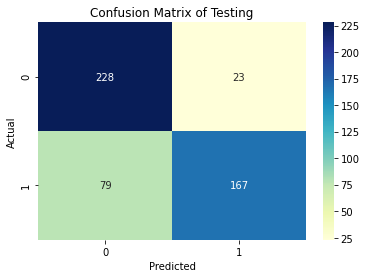

In [20]:
#collapse-hide

data = {'Actual':    testingLabels,
        'Predicted': testingPredictions
        }

df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax = sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d')
ax.set_ylim(2.0, 0)

plt.title('Confusion Matrix of Testing')
plt.show()

## A Closer Look 

Let's look at the general results for our model - notably, we can look at its precision for predicting negative and positive sentiment in a given sentence.

In [21]:
target_names = ['negative', 'positive']
print(classification_report(testingLabels, testingPredictions, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.74      0.91      0.82       251
    positive       0.88      0.68      0.77       246

    accuracy                           0.79       497
   macro avg       0.81      0.79      0.79       497
weighted avg       0.81      0.79      0.79       497



Now, we want to make an interactive confusion matrix so we can precisely see which results are accurately classified and which are mis-classified, as well as the confidence at which the model has classified that result. 

In [22]:
# collapse-hide

# work with the model results to create a JSON dump of the data for future use

import json

output_directory = "libraries/"
output_filename = "predict.json"
full_path = os.path.join(output_directory, output_filename)

data = []
for i in range(len(testingPredictions)):
  data.append({
      'index': i,
      'true_label': int(testingLabels[i]),
      'predicted_label': int(testingPredictions[i]),
      'confidence_score': (test_confidence_scores.tolist())[i],
      'text': testingSentences[i]
  })

with open(full_path, 'w') as outfile:
    json.dump(data, outfile, indent=4, sort_keys=False)

In [23]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import libraries.mlvislib as mlvs

In [24]:
# This is an incomplete proof of concept. Data is being directly referenced in the library,
# and is not being passed over to the ConfusionMatrix object. 
cm = mlvs.ConfusionMatrix(output_filename)
cm.display()